# Evaluation on Robust04

In [1]:
from glob import glob
import pandas as pd
from trectools import TrecQrel
import json
from tqdm import tqdm
from numpy import isnan

EVAL_DIR = '../resources/eval/trec-system-runs/trec13/'
qrel = TrecQrel('../resources/unprocessed/topics-and-qrels/qrels.robust04.txt')

RUNS_TO_SKIP = set([])

# TODO Add unit tests here.
def load_eval_file(file_name, qrels=None):
    ret = []
    unique_queries = set(qrel.qrels_data['query'].astype(str).unique())
    
    eval_result = json.load(open(file_name, 'r'))
    if eval_result['task']['run'] in RUNS_TO_SKIP:
        return None
    
    for pool_name, results in eval_result.items():
        if pool_name in ['task']:
            continue
        covered_queries = set()
        scores = {}
        
        for result in results:
            assert results[0]['run_file'] == result['run_file']
            for eval_measure in result.keys():
                if eval_measure in set(['run_file', 'query']):
                    continue
                measure_name = eval_result['task']['measure'] + '-' + eval_measure
                if measure_name not in scores:
                    scores[measure_name] = []
                
                parsed_score = float(result[eval_measure])
                parsed_score = parsed_score if not isnan(parsed_score) else 0
                scores[measure_name] += [parsed_score]
                covered_queries.add(result['query'])
        
        current_entry = {'run': results[0]['run_file'], 'pooling': pool_name}
        to_update = {k: sum(v)/len(unique_queries) for k,v in scores.items()}
        current_entry.update(to_update)
        
        
        ret += [current_entry]

    return pd.DataFrame(ret)

df = []
for eval_file in tqdm(glob(EVAL_DIR + '*.jsonl')):
    df += [load_eval_file(eval_file)]

df = pd.concat([i for i in df if i is not None])
df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 880/880 [00:16<00:00, 52.07it/s]


,run,pooling,unjudged@20-UNJ@20,unjudged@10-UNJ@10,ndcg@20-NDCG@20,condensed-ndcg@10-NDCG@10,ndcg@10-NDCG@10,condensed-ndcg@20-NDCG@20,residual-ndcg@10-MIN-NDCG@10,residual-ndcg@10-MAX-NDCG@10,residual-ndcg@20-MIN-NDCG@20,residual-ndcg@20-MAX-NDCG@20
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,0.104016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,src/main/resources/processed/normalized-runs/t...,depth-10-pool-incomplete-for-apl,0.166064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-20,0.012851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,src/main/resources/processed/normalized-runs/t...,depth-20-pool-incomplete-for-apl,0.068474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,NaN,0.011245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3,src/main/resources/processed/normalized-runs/t...,depth-20-pool-incomplete-for-sab,NaN,NaN,NaN,NaN,0.415456,NaN,NaN,NaN,NaN,NaN
0,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535712,0.557477
1,src/main/resources/processed/normalized-runs/t...,depth-10-pool-incomplete-for-vtu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529686,0.593904
2,src/main/resources/processed/normalized-runs/t...,complete-pool-depth-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.519096,0.524528


In [2]:
def rename_pooling(pool):
    if pool.startswith('depth-10-pool-incomplete-for-'):
        return 'depth-10-incomplete'
    if pool == 'complete-pool-depth-10':
        return 'depth-10-complete'
    if pool == 'complete-pool-depth-20':
        return 'depth-20-complete'
    if pool.startswith('depth-20-pool-incomplete-for-'):
        return 'depth-20-incomplete'
    
    raise ValueError('I cant handle ' + str(pool))

def rename_measure(m):
    if m == 'unjudged@10-UNJ@10':
        return 'unjudged@10'
    if m == 'condensed-ndcg@10-NDCG@10':
        return 'condensed-ndcg@10'
    if m == 'residual-ndcg@10-MIN-NDCG@10':
        return 'residual-ndcg@10-min'
    if m == 'residual-ndcg@10-MAX-NDCG@10':
        return 'residual-ndcg@10-max'
    if m == 'ndcg@10-NDCG@10':
        return 'ndcg@10'
    if m == 'unjudged@20-UNJ@20':
        return 'unjudged@20'
    if m == 'condensed-ndcg@20-NDCG@20':
        return 'condensed-ndcg@20'
    if m == 'residual-ndcg@20-MIN-NDCG@20':
        return 'residual-ndcg@20-min'
    if m == 'residual-ndcg@20-MAX-NDCG@20':
        return 'residual-ndcg@20-max'
    if m == 'ndcg@20-NDCG@20':
        return 'ndcg@20'

def process_row(df_row):
    df_row = df_row.to_dict()
    pool = rename_pooling(df_row['pooling'])
    
    ret = {}
    for k, v in df_row.items():
        if (type(v) is not float and type(v) is not int) or isnan(v):
            continue
        k = rename_measure(k)
        if k is None:
            continue

        k = (pool, k)
        assert k not in ret
        ret[k] = v
    
    return ret


def process_df(df):
    ret = {}
    run = df.iloc[0]['run']
    for _, i in df.iterrows():
        assert i['run'] == run
        for k, v in process_row(i).items():
            assert k not in ret
            ret[k] = v

    ret['run'] = run
    return pd.DataFrame([ret])

aggregated_df = df.groupby('run').apply(process_df)
aggregated_df

,,"(depth-10-complete, unjudged@10)","(depth-10-incomplete, unjudged@10)","(depth-20-complete, unjudged@10)","(depth-20-incomplete, unjudged@10)","(depth-10-complete, condensed-ndcg@10)","(depth-10-incomplete, condensed-ndcg@10)","(depth-20-complete, condensed-ndcg@10)","(depth-20-incomplete, condensed-ndcg@10)","(depth-10-complete, residual-ndcg@20-min)","(depth-10-complete, residual-ndcg@20-max)",...,"(depth-10-incomplete, residual-ndcg@10-max)","(depth-20-complete, residual-ndcg@10-min)","(depth-20-complete, residual-ndcg@10-max)","(depth-20-incomplete, residual-ndcg@10-min)","(depth-20-incomplete, residual-ndcg@10-max)","(depth-10-complete, ndcg@20)","(depth-10-incomplete, ndcg@20)","(depth-20-complete, ndcg@20)","(depth-20-incomplete, ndcg@20)",run
run,,,,,,,,,,,,,,,,,,,,,,
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDes.gz,0,0.027309,0.127309,0.027309,0.079116,0.492594,0.497944,0.485623,0.488577,0.470979,0.538966,...,0.572838,0.482768,0.504105,0.476176,0.538110,0.470979,0.459263,0.454327,0.447391,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesAggr.gz,0,0.024900,0.123695,0.024900,0.076305,0.501813,0.507116,0.495124,0.497938,0.474598,0.539558,...,0.574730,0.491923,0.510502,0.485236,0.542324,0.474598,0.462708,0.458835,0.451815,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesLaMd.gz,0,0.027309,0.126104,0.027309,0.078715,0.495925,0.501251,0.488800,0.491498,0.473707,0.540697,...,0.576973,0.485945,0.507282,0.479353,0.541321,0.473707,0.462010,0.456545,0.449608,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesQE.gz,0,0.026506,0.130924,0.026506,0.076707,0.485195,0.490829,0.478879,0.482790,0.471433,0.536797,...,0.566817,0.476124,0.493846,0.470151,0.530545,0.471433,0.459837,0.459391,0.450003,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesSwQE.gz,0,0.026908,0.128514,0.026908,0.077510,0.498494,0.502866,0.491766,0.494495,0.476581,0.542674,...,0.579936,0.488859,0.509799,0.482937,0.544430,0.476581,0.464701,0.460261,0.453583,src/main/resources/processed/normalized-runs/t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.vtumtitle.gz,0,0.030924,0.132129,0.030924,0.074297,0.458228,0.472387,0.449815,0.454978,0.449314,0.537172,...,0.538931,0.448025,0.470917,0.443295,0.500270,0.449314,0.443045,0.441803,0.432612,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdo25qla1.gz,0,0.017671,0.106426,0.017671,0.060241,0.467125,0.479846,0.459211,0.466035,0.449660,0.515866,...,0.544741,0.457841,0.469995,0.457390,0.504669,0.449660,0.446291,0.439511,0.436282,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdoqdn1.gz,0,0.007631,0.051807,0.007631,0.023293,0.478656,0.484592,0.471333,0.473690,0.467437,0.509277,...,0.509744,0.470943,0.473975,0.470120,0.484854,0.467437,0.464091,0.451762,0.450406,src/main/resources/processed/normalized-runs/t...


In [6]:
def report_for_row(df_row, depth):
    ground_truth = float(df_row[(f'depth-{depth}-complete', f'ndcg@{depth}')])

    return {
        'run': df_row['run'],
        'unjudged': float(df_row[(f'depth-{depth}-incomplete', f'unjudged@{depth}')]),
        'error-min-residual-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-min')]),
        'error-condensed-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'condensed-ndcg@{depth}')]),
        'error-max-residual-ndcg@10': ground_truth - float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-max')]),
    }

df_report = pd.DataFrame([dict(i) for i in aggregated_df.apply(lambda i: report_for_row(i, 20), axis=1)])
df_report

,run,unjudged,error-min-residual-ndcg@10,error-condensed-ndcg@10,error-max-residual-ndcg@10
0,src/main/resources/processed/normalized-runs/t...,0.131928,0.006937,-0.010444,-0.081581
1,src/main/resources/processed/normalized-runs/t...,0.132329,0.007020,-0.009732,-0.078463
2,src/main/resources/processed/normalized-runs/t...,0.128313,0.006937,-0.009551,-0.082539
3,src/main/resources/processed/normalized-runs/t...,0.127108,0.009387,-0.006258,-0.075804
4,src/main/resources/processed/normalized-runs/t...,0.128514,0.006678,-0.009575,-0.078716
...,...,...,...,...,...
105,src/main/resources/processed/normalized-runs/t...,0.129719,0.009190,-0.010641,-0.082035
106,src/main/resources/processed/normalized-runs/t...,0.099598,0.003229,-0.010094,-0.064699
107,src/main/resources/processed/normalized-runs/t...,0.051807,0.001356,-0.005913,-0.027391
108,src/main/resources/processed/normalized-runs/t...,0.042369,0.000616,-0.005685,-0.013654


In [7]:
df_report.sort_values('unjudged', ascending=False).head(20)

,run,unjudged,error-min-residual-ndcg@10,error-condensed-ndcg@10,error-max-residual-ndcg@10
58,src/main/resources/processed/normalized-runs/t...,0.547590,0.019128,-0.099300,-0.499765
62,src/main/resources/processed/normalized-runs/t...,0.546185,0.007936,-0.079955,-0.497044
63,src/main/resources/processed/normalized-runs/t...,0.371486,0.010359,-0.051355,-0.298185
69,src/main/resources/processed/normalized-runs/t...,0.360040,0.014555,-0.051540,-0.282808
67,src/main/resources/processed/normalized-runs/t...,0.347992,0.006843,-0.039670,-0.283947
64,src/main/resources/processed/normalized-runs/t...,0.339357,0.011863,-0.054491,-0.261386
45,src/main/resources/processed/normalized-runs/t...,0.332530,0.004797,-0.050295,-0.256194
70,src/main/resources/processed/normalized-runs/t...,0.318072,0.009189,-0.039370,-0.244061
66,src/main/resources/processed/normalized-runs/t...,0.295984,0.014121,-0.043321,-0.215140
54,src/main/resources/processed/normalized-runs/t...,0.282329,0.008427,-0.047246,-0.222418


In [12]:
aggregated_df

,,"(depth-10-complete, unjudged@10)","(depth-10-incomplete, unjudged@10)","(depth-20-complete, unjudged@10)","(depth-20-incomplete, unjudged@10)","(depth-10-complete, condensed-ndcg@10)","(depth-10-incomplete, condensed-ndcg@10)","(depth-20-complete, condensed-ndcg@10)","(depth-20-incomplete, condensed-ndcg@10)","(depth-10-complete, residual-ndcg@20-min)","(depth-10-complete, residual-ndcg@20-max)",...,"(depth-10-incomplete, residual-ndcg@10-max)","(depth-20-complete, residual-ndcg@10-min)","(depth-20-complete, residual-ndcg@10-max)","(depth-20-incomplete, residual-ndcg@10-min)","(depth-20-incomplete, residual-ndcg@10-max)","(depth-10-complete, ndcg@20)","(depth-10-incomplete, ndcg@20)","(depth-20-complete, ndcg@20)","(depth-20-incomplete, ndcg@20)",run
run,,,,,,,,,,,,,,,,,,,,,,
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDes.gz,0,0.027309,0.127309,0.027309,0.079116,0.492594,0.497944,0.485623,0.488577,0.470979,0.538966,...,0.572838,0.482768,0.504105,0.476176,0.538110,0.470979,0.459263,0.454327,0.447391,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesAggr.gz,0,0.024900,0.123695,0.024900,0.076305,0.501813,0.507116,0.495124,0.497938,0.474598,0.539558,...,0.574730,0.491923,0.510502,0.485236,0.542324,0.474598,0.462708,0.458835,0.451815,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesLaMd.gz,0,0.027309,0.126104,0.027309,0.078715,0.495925,0.501251,0.488800,0.491498,0.473707,0.540697,...,0.576973,0.485945,0.507282,0.479353,0.541321,0.473707,0.462010,0.456545,0.449608,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesQE.gz,0,0.026506,0.130924,0.026506,0.076707,0.485195,0.490829,0.478879,0.482790,0.471433,0.536797,...,0.566817,0.476124,0.493846,0.470151,0.530545,0.471433,0.459837,0.459391,0.450003,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.JuruDesSwQE.gz,0,0.026908,0.128514,0.026908,0.077510,0.498494,0.502866,0.491766,0.494495,0.476581,0.542674,...,0.579936,0.488859,0.509799,0.482937,0.544430,0.476581,0.464701,0.460261,0.453583,src/main/resources/processed/normalized-runs/t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.vtumtitle.gz,0,0.030924,0.132129,0.030924,0.074297,0.458228,0.472387,0.449815,0.454978,0.449314,0.537172,...,0.538931,0.448025,0.470917,0.443295,0.500270,0.449314,0.443045,0.441803,0.432612,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdo25qla1.gz,0,0.017671,0.106426,0.017671,0.060241,0.467125,0.479846,0.459211,0.466035,0.449660,0.515866,...,0.544741,0.457841,0.469995,0.457390,0.504669,0.449660,0.446291,0.439511,0.436282,src/main/resources/processed/normalized-runs/t...
src/main/resources/processed/normalized-runs/trec-system-runs/trec13/robust/input.wdoqdn1.gz,0,0.007631,0.051807,0.007631,0.023293,0.478656,0.484592,0.471333,0.473690,0.467437,0.509277,...,0.509744,0.470943,0.473975,0.470120,0.484854,0.467437,0.464091,0.451762,0.450406,src/main/resources/processed/normalized-runs/t...


In [30]:
def report_for_row(df_row, depth):
    ground_truth = float(df_row[(f'depth-{depth}-complete', f'ndcg@{depth}')])

    return {
        'run': df_row['run'].split('/')[-1].replace('input.', '').replace('.gz', ''),
        'unjudged': float(df_row[(f'depth-{depth}-incomplete', f'unjudged@{depth}')]),
        f'ground-truth-ndcg@{depth}': ground_truth, 
        f'min-residual-ndcg@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-min')]),
        f'condensed-ndcg@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'condensed-ndcg@{depth}')]),
        f'max-residual-ndcg@{depth}': float(df_row[(f'depth-{depth}-incomplete', f'residual-ndcg@{depth}-max')]),
    }

df_report = pd.DataFrame([dict(i) for i in aggregated_df.apply(lambda i: report_for_row(i, 10), axis=1)])
df_report = df_report.sort_values('ground-truth-ndcg@10', ascending=False).reset_index()
del df_report['index']
df_report

,run,unjudged,ground-truth-ndcg@10,min-residual-ndcg@10,condensed-ndcg@10,max-residual-ndcg@10
0,pircRB04td2,0.057028,0.573118,0.560499,0.577248,0.594387
1,pircRB04td3,0.052209,0.571546,0.559175,0.574442,0.586356
2,fub04TDNge,0.069478,0.555940,0.546311,0.563675,0.594677
3,fub04TDNg,0.093976,0.546996,0.535270,0.562927,0.598576
4,fub04TDNe,0.028916,0.542307,0.540722,0.544287,0.556404
...,...,...,...,...,...,...
105,humR04d5i,0.325301,0.332811,0.325831,0.398848,0.591852
106,mpi04r08,0.340964,0.315171,0.304310,0.364858,0.594658
107,icl04pos2t,0.283133,0.306328,0.292435,0.364879,0.535089
108,mpi04r02,0.568675,0.197609,0.184661,0.309229,0.712589


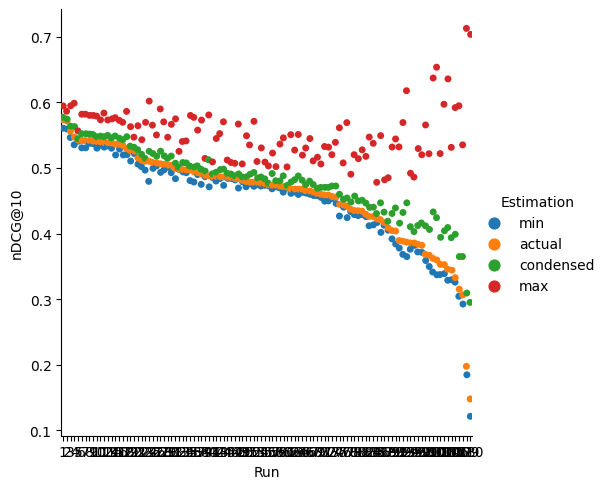

In [43]:
df_for_plot = []

for pos, i in df_report.iterrows():
    for k,v in [('min', 'min-residual-ndcg@10'), ('max', 'max-residual-ndcg@10'), ('actual', 'ground-truth-ndcg@10'), ('condensed', 'condensed-ndcg@10')]:
        df_for_plot += [{'Run': pos+1, 'Estimation': k, 'nDCG@10': i[v]}]

df_for_plot = pd.DataFrame(df_for_plot)

sns.catplot(
    data=df_for_plot,
    x='Run', y='nDCG@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

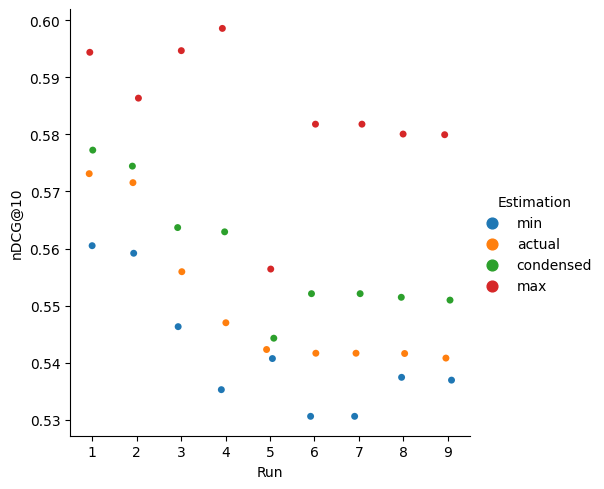

In [44]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 10],
    x='Run', y='nDCG@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)

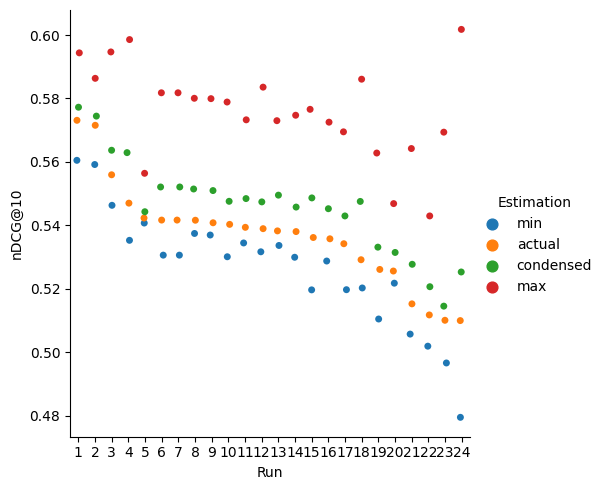

In [45]:
sns.catplot(
    data=df_for_plot[df_for_plot['Run'] < 25],
    x='Run', y='nDCG@10',
    hue='Estimation',
    hue_order=['min', 'actual', 'condensed', 'max'],
)